In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
import time
from scipy import ndimage
%matplotlib inline

### CIFAR-10

In [2]:
random_seed = 142857
rng = np.random.RandomState(random_seed)
train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

In [10]:
def data_augmentation(image, theight, twidth, whitten_image = True):
    # augmentation by croping the images target_height = 36, target_width = 36
    padding_image = tf.map_fn(lambda img: tf.image.resize_image_with_crop_or_pad(img, 36, 36), image)
    
    flip_image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), padding_image)
    if whitten_image:
        new_image = tf.map_fn(lambda img: tf.image.resize_image_with_crop_or_pad(img,twidth,theight),flip_image)
        # whitten_image = tf.map_fn(lambda img: tf.image.per_image_standardization(img), new_image)
        return new_image
    else:
        rndx = np.random.randint(4)
        rndy = np.random.randint(4)
        new_image = tf.map_fn(lambda img: tf.image.crop_to_bounding_box(img,rndx,rndy,twidth,theight),flip_image)
        # new_image = tf.image.resize_image_with_crop_or_pad(flip_image, theight, twidth) 
        return new_image
    # flip_image = tf.image.random_flip_left_right(image)

1


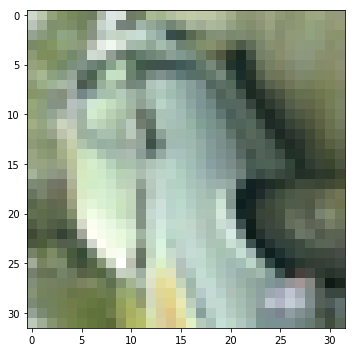

In [4]:
#print train_data.inputs[0]

fig = plt.figure(figsize=(5,5))

# im = np.empty((32,32,3))

# for i in range(123,223):
im = train_data.inputs[7].reshape((3,32,32)).T
print train_data.targets[7]
# print im
im = im.astype(np.float32)
#im = ndimage.rotate(im,270,reshape=False)
    # print im.shape
ax = fig.add_subplot(1,1,1)
ax.imshow(im)
#ax.axis('off')
fig.tight_layout()
plt.show()

fig.savefig('Tresult.png',dpi=200)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


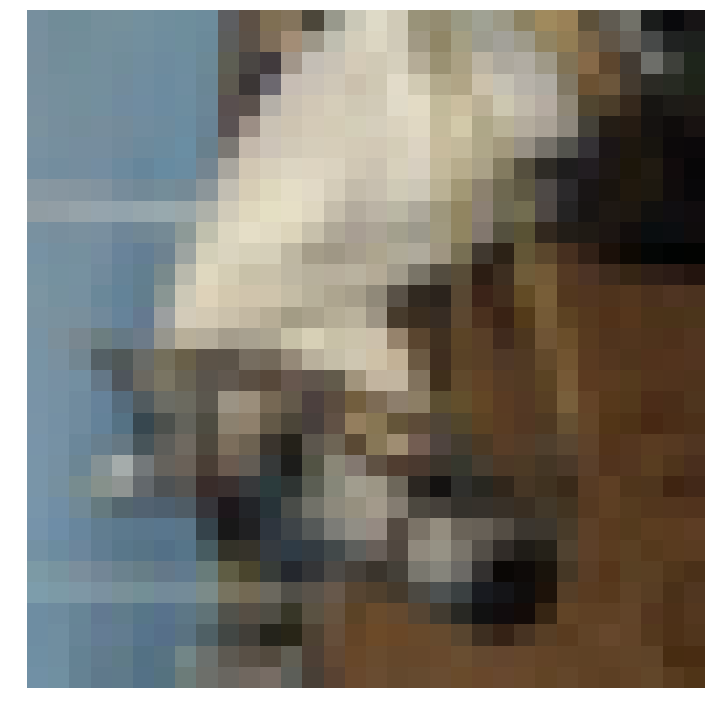

In [16]:
fig = plt.figure(figsize=(10,10))

# im = np.empty((32,32,3))
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

# for i in range(222,223):
#for x in range(5):
#    for y in range(5):
im = train_data.inputs[654].reshape((3,32,32)).T
# print im
im = im.astype(np.float32)
        # im = ndimage.rotate(im,269.5)
im = im.reshape((-1,32,32,3))
        # print im.shape
im = data_augmentation(im, 32, 32,whitten_image=True)
im = tf.reshape(im,(32,32,3))
im = sess.run(im)
ax = fig.add_subplot(1,1,1)
ax.imshow(im)
ax.axis('off')
fig.tight_layout()
plt.show()

fig.savefig('rotated4.png',dpi=200)

In [99]:
def data_augmentation_rotate(image, theight, twidth, whitten_image = True):
    # augmentation by croping the images target_height = 36, target_width = 36
    #padding_image = tf.map_fn(lambda img:  tf.image.resize_image_with_crop_or_pad(img, 36, 36), image)
    # flip_image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), padding_image)
    rnk = np.random.randint(4)
    rotated_image = tf.map_fn(lambda img: tf.image.rot90(img,k=rnk), image)
    tf.map_fn(lambda img: tf.transpose(img),image)
    return rotated_image
    # print rotated_image
    # rotated_image = tf.map_fn(lambda img: ndimage.rotate(img,269.5,reshape=False), rotated_image)
    
    if whitten_image:
        whitten_image = tf.map_fn(lambda img: tf.image.per_image_standardization(img), flip_image)
        return whitten_image
    else:
        rndx = np.random.randint(3)
        rndy = np.random.randint(3)
        new_image = tf.map_fn(lambda img: tf.image.crop_to_bounding_box(img,rndx,rndy,twidth,theight),rotated_image)
        # new_image = tf.image.resize_image_with_crop_or_pad(flip_image, theight, twidth) 
        return new_image
    # flip_image = tf.image.random_flip_left_right(image)

In [121]:
def data_augmentation(image, theight, twidth,cropx,cropy ,whitten_image = True):
    # augmentation by croping the images target_height = 36, target_width = 36
    padding_image = tf.map_fn(lambda img:  tf.image.resize_image_with_crop_or_pad(img, 36, 36), image)
    flip_image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), padding_image)
    if whitten_image:
        whitten_image = tf.map_fn(lambda img: tf.image.per_image_standardization(img), flip_image)
        return whitten_image
    else:
        rndx = np.random.randint(4)
        rndy = np.random.randint(4)
        new_image = tf.map_fn(lambda img: tf.image.crop_to_bounding_box(img,cropx,cropy,twidth,theight),flip_image)
        # new_image = tf.image.resize_image_with_crop_or_pad(flip_image, theight, twidth) 
        return new_image
    # flip_image = tf.image.random_flip_left_right(image)

In [23]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden = 200
beta_l1 = 0.001
beta_l2 = 0.001


with tf.name_scope('fc-layer-1'):
    hidden_1, weights_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2,weights_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weights_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weights_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)
    
with tf.name_scope('L2-regularisation'):
    L2_regu = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4)

with tf.name_scope('L1-regularisation'):
    L1_regu = (tf.reduce_sum(tf.abs(weights_1))+tf.reduce_sum(tf.abs(weights_2))+
                tf.reduce_sum(tf.abs(weights_3))+tf.reduce_sum(tf.abs(weights_4)))

with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l2 * L2_regu + beta_l1 * L1_regu
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001,epsilon=0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [15]:
train_log = {'epoch_num':[],
             'running_error':[],
             'running_accuracy':[],
             'running_time':[]
            }
valid_log = {'epoch_num':[],
             'running_error':[],
             'running_accuracy':[],
            }
train_data.reset()
valid_data.reset()

with tf.Session() as sess:
    sess.run(init)
    for e in range(50):
        running_error = 0.
        running_accuracy = 0.
        start_time = time.time()
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        epoch_time = time.time() - start_time
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        train_log['epoch_num'].append(e+1)
        train_log['running_error'].append(running_error)
        train_log['running_accuracy'].append(running_accuracy)
        train_log['running_time'].append(epoch_time)
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} time(train)={3:.2f}'
              .format(e + 1, running_error, running_accuracy, epoch_time))
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_log['epoch_num'].append(e+1)
            valid_log['running_error'].append(valid_error)
            valid_log['running_accuracy'].append(valid_accuracy)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))

End of epoch 01: err(train)=2.51 acc(train)=0.32 time(train)=8.12
End of epoch 02: err(train)=2.29 acc(train)=0.39 time(train)=7.16
End of epoch 03: err(train)=2.19 acc(train)=0.42 time(train)=7.05
End of epoch 04: err(train)=2.10 acc(train)=0.44 time(train)=7.10
End of epoch 05: err(train)=2.04 acc(train)=0.46 time(train)=6.98
                 err(valid)=2.06 acc(valid)=0.44
End of epoch 06: err(train)=1.98 acc(train)=0.47 time(train)=7.24
End of epoch 07: err(train)=1.93 acc(train)=0.48 time(train)=7.32
End of epoch 08: err(train)=1.89 acc(train)=0.49 time(train)=7.27
End of epoch 09: err(train)=1.85 acc(train)=0.50 time(train)=7.10
End of epoch 10: err(train)=1.81 acc(train)=0.51 time(train)=7.03
                 err(valid)=1.93 acc(valid)=0.47
End of epoch 11: err(train)=1.78 acc(train)=0.52 time(train)=7.32
End of epoch 12: err(train)=1.75 acc(train)=0.52 time(train)=7.43
End of epoch 13: err(train)=1.73 acc(train)=0.53 time(train)=6.94
End of epoch 14: err(train)=1.70 acc(train)=

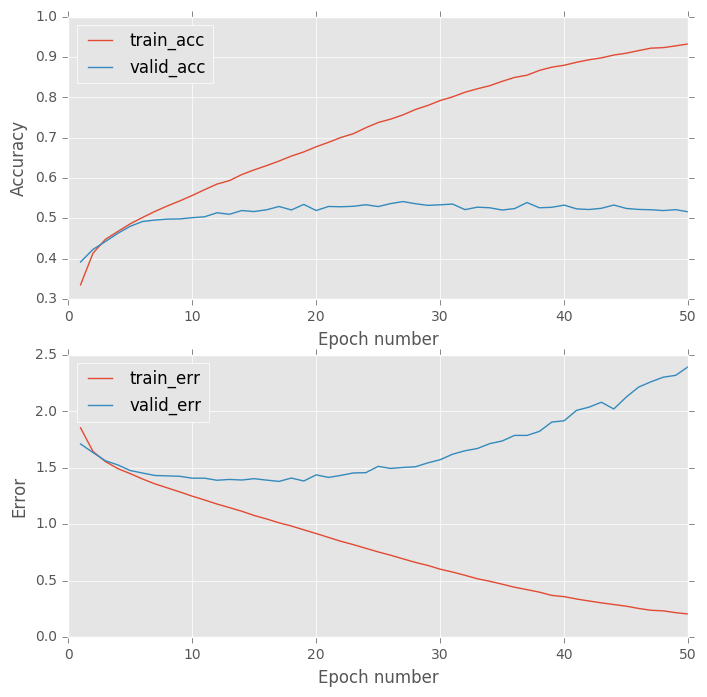

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

#print train_log

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(train_log['epoch_num'],train_log['running_accuracy'],label='train_acc')
ax1.plot(valid_log['epoch_num'],valid_log['running_accuracy'],label='valid_acc')
ax2.plot(train_log['epoch_num'],train_log['running_error'],label='train_err')
ax2.plot(valid_log['epoch_num'],valid_log['running_error'],label='valid_err')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Accuracy')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Error')

plt.show()

### Dropout

In [24]:
def fully_connected_layer(inputs, input_dim, output_dim, keep_prob,nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases),keep_prob)
    return outputs, weights

In [34]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden = 200
beta_l1 = 0.001
beta_l2 = 0.0001

keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('fc-layer-1'):
    hidden_1, weights_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden,keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2,weights_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden,keep_prob)
with tf.name_scope('fc-layer-3'):
    hidden_3, weights_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden,keep_prob)
with tf.name_scope('output-layer'):
    outputs, weights_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, keep_prob, tf.identity)
    
with tf.name_scope('L2-regularisation'):
    L2_regu = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4)

with tf.name_scope('L1-regularisation'):
    L1_regu = (tf.reduce_sum(tf.abs(weights_1))+tf.reduce_sum(tf.abs(weights_2))+
                tf.reduce_sum(tf.abs(weights_3))+tf.reduce_sum(tf.abs(weights_4)))

with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1*L1_regu + beta_l2*L2_regu
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001,epsilon=0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [35]:
train_log = {'epoch_num':[],
             'running_error':[],
             'running_accuracy':[],
             'running_time':[]
            }
valid_log = {'epoch_num':[],
             'running_error':[],
             'running_accuracy':[],
            }
train_data.reset()
valid_data.reset()

with tf.Session() as sess:
    sess.run(init)
    for e in range(50):
        running_error = 0.
        running_accuracy = 0.
        start_time = time.time()
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:0.8})
            running_error += batch_error
            running_accuracy += batch_acc
        epoch_time = time.time() - start_time
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        train_log['epoch_num'].append(e+1)
        train_log['running_error'].append(running_error)
        train_log['running_accuracy'].append(running_accuracy)
        train_log['running_time'].append(epoch_time)
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} time(train)={3:.2f}'
              .format(e + 1, running_error, running_accuracy, epoch_time))
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_log['epoch_num'].append(e+1)
            valid_log['running_error'].append(valid_error)
            valid_log['running_accuracy'].append(valid_accuracy)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))

End of epoch 01: err(train)=19.77 acc(train)=0.21 time(train)=12.24
End of epoch 02: err(train)=11.85 acc(train)=0.27 time(train)=12.17
End of epoch 03: err(train)=7.40 acc(train)=0.29 time(train)=12.11
End of epoch 04: err(train)=5.22 acc(train)=0.29 time(train)=12.23
End of epoch 05: err(train)=4.03 acc(train)=0.29 time(train)=12.31
                 err(valid)=3.53 acc(valid)=0.35
End of epoch 06: err(train)=3.35 acc(train)=0.29 time(train)=12.18
End of epoch 07: err(train)=2.96 acc(train)=0.28 time(train)=12.17
End of epoch 08: err(train)=2.74 acc(train)=0.28 time(train)=12.21
End of epoch 09: err(train)=2.59 acc(train)=0.27 time(train)=12.15
End of epoch 10: err(train)=2.51 acc(train)=0.27 time(train)=12.29
                 err(valid)=2.40 acc(valid)=0.32
End of epoch 11: err(train)=2.44 acc(train)=0.26 time(train)=12.17
End of epoch 12: err(train)=2.40 acc(train)=0.26 time(train)=12.16
End of epoch 13: err(train)=2.36 acc(train)=0.26 time(train)=12.19
End of epoch 14: err(train)=2

### CIFAR-100

In [6]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

In [7]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden = 200

with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
    
init = tf.global_variables_initializer()

In [8]:
sess = tf.Session()
sess.run(init)
for e in range(10):
    running_error = 0.
    running_accuracy = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_accuracy += batch_acc
    running_error /= train_data.num_batches
    running_accuracy /= train_data.num_batches
    print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
          .format(e + 1, running_error, running_accuracy))
    if (e + 1) % 5 == 0:
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
               .format(valid_error, valid_accuracy))

End of epoch 01: err(train)=4.33 acc(train)=0.04
End of epoch 02: err(train)=4.05 acc(train)=0.07
End of epoch 03: err(train)=3.94 acc(train)=0.09
End of epoch 04: err(train)=3.88 acc(train)=0.10
End of epoch 05: err(train)=3.84 acc(train)=0.11
                 err(valid)=3.82 acc(valid)=0.11
End of epoch 06: err(train)=3.81 acc(train)=0.11
End of epoch 07: err(train)=3.80 acc(train)=0.12
End of epoch 08: err(train)=3.79 acc(train)=0.12
End of epoch 09: err(train)=3.78 acc(train)=0.12
End of epoch 10: err(train)=3.76 acc(train)=0.12
                 err(valid)=3.80 acc(valid)=0.11


## Predicting test data classes and creating a Kaggle submission file

An optional [Kaggle in Class](https://inclass.kaggle.com/c/ml2016-7-cifar-100) competition (see email for invite link, you will need to sign-up with a `ed.ac.uk` email address to be able to enter) is being run on the CIFAR-100 (fine-grained) classification task. The scores for the competition are calculated by calculating the proportion of classes correctly predicted on the test set inputs (for which no class labels are provided). Half of the 10000 test inputs are used to calculate a public leaderboard score which will be visible while the competition is in progress and the other half are used to compute the private leaderboard score which will only be unveiled at the end of the competition. Each entrant can make up to two submissions of predictions each day during the competition.

The code and helper function below illustrate how to use the predicted outputs of the TensorFlow network model we just trained to create a submission file which can be uploaded to Kaggle. The required format of the submission file is a `.csv` (Comma Separated Variable) file with two columns: the first is the integer index of the test input in the array in the provided data file (i.e. first row 0, second row 1 and so on) and the second column the corresponding predicted class label as an integer between 0 and 99 inclusive. The predictions must be preceded by a header line as in the following example

```
Id,Class
0,81
1,35
2,12
...
```

Integer class label predictions can be computed from the class probability outputs of the model by performing an `argmax` operation along the last dimension.

In [ ]:
test_inputs = np.load(os.path.join(os.environ['MLP_DATA_DIR'], 'cifar-100-test-inputs.npz'))['inputs']
test_predictions = sess.run(tf.nn.softmax(outputs), feed_dict={inputs: test_inputs})

In [ ]:
def create_kaggle_submission_file(predictions, output_file, overwrite=False):
    if predictions.shape != (10000, 100):
        raise ValueError('predictions should be an array of shape (10000, 25).')
    if not (np.all(predictions >= 0.) and 
            np.all(predictions <= 1.)):
        raise ValueError('predictions should be an array of probabilities in [0, 1].')
    if not np.allclose(predictions.sum(-1), 1):
        raise ValueError('predictions rows should sum to one.')
    if os.path.exists(output_file) and not overwrite:
        raise ValueError('File already exists at {0}'.format(output_file))
    pred_classes = predictions.argmax(-1)
    ids = np.arange(pred_classes.shape[0])
    np.savetxt(output_file, np.column_stack([ids, pred_classes]), fmt='%d',
               delimiter=',', header='Id,Class', comments='')

In [ ]:
create_kaggle_submission_file(test_predictions, 'cifar-100-example-network-submission.csv', True)